In [ ]:
####################################################

#ahora aplicaremos SMOTE y agrego una nueva métrica 

####################################################

In [50]:
#svm 3
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE, RandomOverSampler

# === 1. Datos ===
X = tfidf_dataframe_2.to_numpy()
y = data['SubRubro_encoded'].reset_index(drop=True)

# === 2. Modelo SVM con hiperparámetros ajustados ===
modelo = SVC(C=10, kernel='linear', gamma='scale')

# === 3. Validación cruzada ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = []
y_true_bin = []
y_pred_bin = []

inicio_total = time.time()

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"\nPliegue {fold}:")
    print(f"  Registros en entrenamiento: {len(train_idx)}")
    print(f"  Registros en prueba:        {len(test_idx)}")

    try:
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print(f"  Registros después de SMOTE: {len(X_train_res)}")
    except ValueError:
        print("⚠️ SMOTE no aplicable, usando RandomOverSampler")
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    inicio = time.time()
    modelo.fit(X_train_res, y_train_res)
    y_pred = modelo.predict(X_test)
    fin = time.time()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    tiempo = fin - inicio

    resultados.append({
        'Pliegue': fold,
        'Accuracy': acc,
        'Precisión Weighted': prec,
        'Recall Macro': rec,
        'F1-Score Macro': f1_macro,
        'F1-Score Weighted': f1_weighted,
        'Tiempo (s)': tiempo
    })

    binaria = (y_pred == y_test).astype(int)
    y_true_bin.extend([1] * len(binaria))
    y_pred_bin.extend(binaria)

# === 4. Mostrar métricas ===
resultados_df = pd.DataFrame(resultados)
print("\n📊 Resultados por pliegue:")
print(resultados_df.round(4))

print("\n📈 Promedios globales:")
print(resultados_df.drop(columns="Pliegue").mean().to_frame().T.round(4))

fin_total = time.time()
print(f"\n⏱️ Tiempo total de ejecución: {round(fin_total - inicio_total, 2)} segundos")




Pliegue 1:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 2:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 3:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 4:
  Registros en entrenamiento: 3127
  Registros en prueba:        781
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 5:
  Registros en entrenamiento: 3127
  Registros en prueba:        781
⚠️ SMOTE no aplicable, usando RandomOverSampler

📊 Resultados por pliegue:
   Pliegue  Accuracy  Precisión Weighted  Recall Macro  F1-Score Macro  \
0        1    0.6253              0.7425        0.4774          0.4972   
1        2    0.6765              0.7827        0.5295          0.5332   
2        3    0.6624              0.7844        0.5640          0.5594   
3        4    0.6389            

In [51]:
#random forest
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE, RandomOverSampler

# === 1. Datos ===
X = tfidf_dataframe_2.to_numpy()
y_original = data['SubRubro_encoded'].reset_index(drop=True)

# Filtrar clases con al menos 2 ejemplos
conteo = y_original.value_counts()
clases_validas = conteo[conteo >= 2].index
mask = y_original.isin(clases_validas)
X = X[mask]
y = y_original[mask].reset_index(drop=True)

# === 2. Validación cruzada ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = []
y_true_bin = []
y_pred_bin = []

inicio_total = time.time()

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_orig = y.iloc[train_idx].reset_index(drop=True)
    y_test_orig = y.iloc[test_idx].reset_index(drop=True)

    # Mapear las clases locales por pliegue
    clases_unicas = np.sort(y_train_orig.unique())
    clase_a_indice = {clase: i for i, clase in enumerate(clases_unicas)}
    y_train = y_train_orig.map(clase_a_indice)
    y_test = y_test_orig.map(clase_a_indice)

    # === Aplicar SMOTE o fallback a RandomOverSampler ===
    try:
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print(f"\nPliegue {fold}:")
        print(f"  Registros en entrenamiento antes de SMOTE: {len(X_train)}")
        print(f"  Registros después de SMOTE:                {len(X_train_res)}")
    except ValueError:
        print(f"\nPliegue {fold}: ⚠️ SMOTE no aplicable, usando RandomOverSampler")
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    print(f"  Registros en prueba:        {len(X_test)}")
    print(f"  Clases en pliegue:          {len(clases_unicas)}")

    modelo = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    inicio = time.time()
    modelo.fit(X_train_res, y_train_res)
    y_pred = modelo.predict(X_test)
    fin = time.time()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    tiempo = fin - inicio

    resultados.append({
        'Pliegue': fold,
        'Accuracy': acc,
        'Precisión Weighted': prec,
        'Recall Macro': rec,
        'F1-Score Macro': f1_macro,
        'F1-Score Weighted': f1_weighted,
        'Tiempo (s)': tiempo
    })

    # Clasificación binaria: bien vs mal clasificado
    bien_clasificado = (y_pred == y_test).astype(int)
    y_true_bin.extend([1] * len(bien_clasificado))
    y_pred_bin.extend(bien_clasificado)

# === 3. Resultados promedio ===
resultados_df = pd.DataFrame(resultados)
print("\n📊 Resultados por pliegue:")
print(resultados_df.round(4))

print("\n📈 Promedios globales:")
print(resultados_df.drop(columns="Pliegue").mean().to_frame().T.round(4))

print(f"\n⏱️ Tiempo total: {round(time.time() - inicio_total, 2)} segundos")




Pliegue 1: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        780
  Clases en pliegue:          105

Pliegue 2: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        780
  Clases en pliegue:          105

Pliegue 3: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        779
  Clases en pliegue:          105

Pliegue 4: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        779
  Clases en pliegue:          105

Pliegue 5: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        779
  Clases en pliegue:          105

📊 Resultados por pliegue:
   Pliegue  Accuracy  Precisión Weighted  Recall Macro  F1-Score Macro  \
0        1    0.6949              0.7301        0.5312          0.5149   
1        2    0.7128              0.7502        0.6129          0.5953   
2        3    0.6945              0.7457        0.5863          0.5549   
3        4    0.6893              0.7

In [52]:
#XBboots
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler

# === 1. Datos ===
X = tfidf_dataframe_2.to_numpy()
y_original = data['SubRubro_encoded'].reset_index(drop=True)

# Filtrar clases con al menos 2 ejemplos
conteo = y_original.value_counts()
clases_validas = conteo[conteo >= 2].index
mask = y_original.isin(clases_validas)
X = X[mask]
y = y_original[mask].reset_index(drop=True)

# === 2. Validación cruzada ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = []
y_true_bin = []
y_pred_bin = []

inicio_total = time.time()

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train_orig = y.iloc[train_idx].reset_index(drop=True)
    y_test_orig = y.iloc[test_idx].reset_index(drop=True)

    # Mapear clases locales
    clases_unicas = np.sort(y_train_orig.unique())
    clase_a_indice = {clase: i for i, clase in enumerate(clases_unicas)}
    y_train = y_train_orig.map(clase_a_indice)
    y_test = y_test_orig.map(clase_a_indice)

    # === Aplicar SMOTE o RandomOverSampler si hay clases con muy pocos ejemplos ===
    try:
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print(f"\nPliegue {fold}:")
        print(f"  Registros entrenamiento antes de SMOTE: {len(X_train)}")
        print(f"  Registros después de SMOTE:            {len(X_train_res)}")
    except ValueError:
        print(f"\nPliegue {fold}: ⚠️ SMOTE no aplicable, usando RandomOverSampler")
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    print(f"  Registros en prueba:        {len(X_test)}")
    print(f"  Clases en pliegue:          {len(clases_unicas)}")

    modelo = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softmax',
        num_class=len(clases_unicas),
        colsample_bytree=0.8,
        gamma=0,
        learning_rate=0.2,
        max_depth=6,
        min_child_weight=1,
        n_estimators=50,
        reg_lambda=1,
        subsample=0.8,
        verbosity=0
    )

    inicio = time.time()
    modelo.fit(X_train_res, y_train_res)
    y_pred = modelo.predict(X_test)
    fin = time.time()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    tiempo = fin - inicio

    resultados.append({
        'Pliegue': fold,
        'Accuracy': acc,
        'Precisión Weighted': prec,
        'Recall Macro': rec,
        'F1-Score Macro': f1_macro,
        'F1-Score Weighted': f1_weighted,
        'Tiempo (s)': tiempo
    })

    # Matriz binaria de aciertos vs errores
    binaria = (y_pred == y_test).astype(int)
    y_true_bin.extend([1] * len(binaria))
    y_pred_bin.extend(binaria)

# === 3. Mostrar métricas ===
resultados_df = pd.DataFrame(resultados)
print("\n📊 Resultados por pliegue:")
print(resultados_df.round(4))

print("\n📈 Promedios globales:")
print(resultados_df.drop(columns="Pliegue").mean().to_frame().T.round(4))

print(f"\n⏱️ Tiempo total: {round(time.time() - inicio_total, 2)} segundos")



Pliegue 1: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        780
  Clases en pliegue:          105

Pliegue 2: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        780
  Clases en pliegue:          105

Pliegue 3: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        779
  Clases en pliegue:          105

Pliegue 4: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        779
  Clases en pliegue:          105

Pliegue 5: ⚠️ SMOTE no aplicable, usando RandomOverSampler
  Registros en prueba:        779
  Clases en pliegue:          105

📊 Resultados por pliegue:
   Pliegue  Accuracy  Precisión Weighted  Recall Macro  F1-Score Macro  \
0        1    0.6026              0.6816        0.4783          0.4809   
1        2    0.6192              0.7274        0.5554          0.5542   
2        3    0.5982              0.6990        0.5051          0.4948   
3        4    0.6008              0.6

In [53]:
#knn
#En algunos pliegues, debido a la baja frecuencia de ciertas clases, SMOTE no pudo aplicarse 
#(por requerir al menos 2 muestras por clase). En esos casos se utilizó RandomOverSampler 
#como técnica de balanceo alternativa para permitir el entrenamiento del modelo sin interrupciones.
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE, RandomOverSampler

# === 1. Datos ===
X = tfidf_dataframe_2.to_numpy()
y = data['SubRubro_encoded'].reset_index(drop=True)

# === 2. Definir modelo con mejores hiperparámetros ===
modelo = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')

# === 3. Validación cruzada ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = []
y_true_bin = []
y_pred_bin = []

inicio_total = time.time()

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"\nPliegue {fold}:")
    print(f"  Registros entrenamiento antes de SMOTE: {len(X_train)}")
    print(f"  Registros prueba:                       {len(X_test)}")

    # === Aplicar SMOTE (o RandomOverSampler si es necesario) ===
    try:
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print(f"  Registros entrenamiento después de SMOTE: {len(X_train_res)}")
    except ValueError:
        print(f"  ⚠️ SMOTE no aplicable, usando RandomOverSampler")
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # === Entrenamiento y predicción ===
    inicio = time.time()
    modelo.fit(X_train_res, y_train_res)
    y_pred = modelo.predict(X_test)
    fin = time.time()

    # === Cálculo de métricas ===
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    tiempo = fin - inicio

    resultados.append({
        'Pliegue': fold,
        'Accuracy': acc,
        'Precisión Weighted': prec,
        'Recall Macro': rec,
        'F1-Score Macro': f1_macro,
        'F1-Score Weighted': f1_weighted,
        'Tiempo (s)': tiempo
    })

    # === Binaria: Bien vs Mal Clasificado ===
    binaria = (y_pred == y_test).astype(int)
    y_true_bin.extend([1] * len(binaria))  # se espera acertar (1)
    y_pred_bin.extend(binaria)             # 1 si acertó, 0 si falló

# === 4. Mostrar métricas ===
resultados_df = pd.DataFrame(resultados)
print("\n📊 Resultados por pliegue:")
print(resultados_df.round(4))

print("\n📈 Promedios globales:")
print(resultados_df.drop(columns="Pliegue").mean().to_frame().T.round(4))

fin_total = time.time()
print(f"\n⏱️ Tiempo total de ejecución: {round(fin_total - inicio_total, 2)} segundos")




Pliegue 1:
  Registros entrenamiento antes de SMOTE: 3126
  Registros prueba:                       782
  ⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 2:
  Registros entrenamiento antes de SMOTE: 3126
  Registros prueba:                       782
  ⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 3:
  Registros entrenamiento antes de SMOTE: 3126
  Registros prueba:                       782
  ⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 4:
  Registros entrenamiento antes de SMOTE: 3127
  Registros prueba:                       781
  ⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 5:
  Registros entrenamiento antes de SMOTE: 3127
  Registros prueba:                       781
  ⚠️ SMOTE no aplicable, usando RandomOverSampler

📊 Resultados por pliegue:
   Pliegue  Accuracy  Precisión Weighted  Recall Macro  F1-Score Macro  \
0        1    0.5499              0.7999        0.4569          0.4888   
1        2    0.5639              0.7992        0.

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Pliegue 1:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Pliegue 2:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Pliegue 3:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Pliegue 4:
  Registros en entrenamiento: 3127
  Registros en prueba:        781
⚠️ SMOTE no aplicable, usando RandomOverSampler


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Pliegue 5:
  Registros en entrenamiento: 3127
  Registros en prueba:        781
⚠️ SMOTE no aplicable, usando RandomOverSampler


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



📊 Resultados por pliegue:
   Pliegue  Accuracy  Precisión Weighted  Recall Macro  F1-Score Macro  \
0        1    0.6829              0.7411        0.5168          0.5142   
1        2    0.7199              0.7708        0.5797          0.5636   
2        3    0.7110              0.7716        0.5880          0.5788   
3        4    0.6812              0.7510        0.5284          0.5193   
4        5    0.7324              0.7829        0.5895          0.5743   

   F1-Score Weighted  Tiempo (s)  
0             0.7004  54926.9590  
1             0.7344  51144.8132  
2             0.7337  54736.9580  
3             0.7057  54471.8721  
4             0.7490  55188.6198  

📈 Promedios globales:
   Accuracy  Precisión Weighted  Recall Macro  F1-Score Macro  \
0    0.7055              0.7635        0.5605            0.55   

   F1-Score Weighted  Tiempo (s)  
0             0.7246  54093.8444  

⏱️ Tiempo total de ejecución: 270481.42 segundos


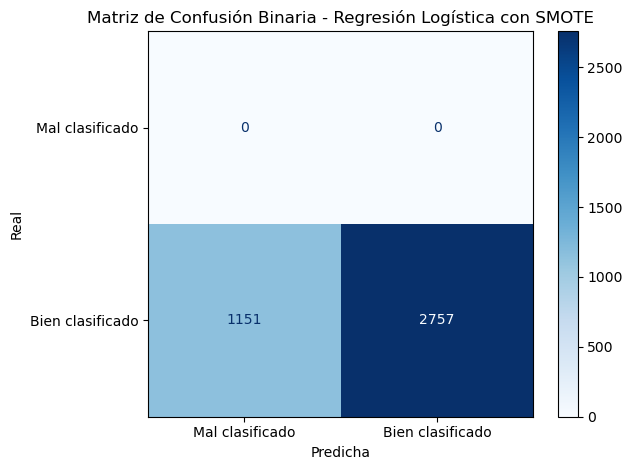

In [35]:
#Regresion logistica
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)
from imblearn.over_sampling import SMOTE, RandomOverSampler

# === 1. Datos ===
X = tfidf_dataframe_2.to_numpy()
y = data['SubRubro_encoded'].reset_index(drop=True)

# === 2. Modelo con hiperparámetros ajustados ===
modelo = LogisticRegression(
    C=100,
    max_iter=500,
    multi_class='multinomial',
    penalty='l2',
    solver='saga'
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = []
y_true_bin = []
y_pred_bin = []

inicio_total = time.time()

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"\nPliegue {fold}:")
    print(f"  Registros en entrenamiento: {len(X_train)}")
    print(f"  Registros en prueba:        {len(X_test)}")

    # === Aplicar SMOTE o RandomOverSampler ===
    try:
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print(f"  Registros después de SMOTE: {len(X_train_res)}")
    except ValueError:
        print("⚠️ SMOTE no aplicable, usando RandomOverSampler")
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # === Entrenamiento y predicción ===
    inicio = time.time()
    modelo.fit(X_train_res, y_train_res)
    y_pred = modelo.predict(X_test)
    fin = time.time()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    tiempo = fin - inicio

    resultados.append({
        'Pliegue': fold,
        'Accuracy': acc,
        'Precisión Weighted': prec,
        'Recall Macro': rec,
        'F1-Score Macro': f1_macro,
        'F1-Score Weighted': f1_weighted,
        'Tiempo (s)': tiempo
    })

    # Matriz binaria: 1 si acierto, 0 si error
    binaria = (y_pred == y_test).astype(int)
    y_true_bin.extend([1] * len(binaria))  # lo esperado: acertar
    y_pred_bin.extend(binaria)

# === 3. Mostrar métricas ===
resultados_df = pd.DataFrame(resultados)
print("\n📊 Resultados por pliegue:")
print(resultados_df.round(4))

print("\n📈 Promedios globales:")
print(resultados_df.drop(columns="Pliegue").mean().to_frame().T.round(4))

fin_total = time.time()
print(f"\n⏱️ Tiempo total de ejecución: {round(fin_total - inicio_total, 2)} segundos")


In [29]:
#prueba de modelo y matriz por clases.
#es para entender como se aplicar e lmodelo por clase.
import numpy as np
from sklearn.metrics import (
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import os

# Lista de clases únicas del dataset
clases = np.unique(y_test_total)

# Crear carpeta para guardar imágenes
carpeta_salida = "matrices_binarias_ovr"
os.makedirs(carpeta_salida, exist_ok=True)

for clase in clases:
    print(f"\n🔍 Evaluando Clase '{clase}' (One-vs-Rest)")

    # Etiquetas binarias para clase actual
    y_true_bin = (y_test_total == clase).astype(int)
    y_pred_bin = (y_pred_total == clase).astype(int)

    # Matriz de confusión binaria
    matriz_binaria = confusion_matrix(y_true_bin, y_pred_bin)

    # Mostrar matriz en consola
    print("                Predicho")
    print("               No    Sí")
    print(f"Real No     {matriz_binaria[0,0]}   {matriz_binaria[0,1]}")
    print(f"Real Sí     {matriz_binaria[1,0]}   {matriz_binaria[1,1]}")

    # Reporte de métricas
    print("\n📊 Métricas:")
    print(classification_report(
        y_true_bin, y_pred_bin,
        target_names=["No " + str(clase), str(clase)],
        zero_division=0
    ))

    # Mostrar y guardar el gráfico
    disp = ConfusionMatrixDisplay(
        confusion_matrix=matriz_binaria,
        display_labels=["No " + str(clase), str(clase)]
    )
    disp.plot(cmap='YlGnBu')
    plt.title(f"Matriz Binaria (Clase {clase} vs Resto)")
    plt.grid(False)

    # Guardar imagen
    nombre_archivo = os.path.join(carpeta_salida, f"matriz_binaria_clase_{clase}.png")
    plt.savefig(nombre_archivo, bbox_inches='tight')
    plt.close()

    print(f"✅ Imagen guardada en: {nombre_archivo}")



🔍 Evaluando Clase '0' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3836   5
Real Sí     35   32

📊 Métricas:
              precision    recall  f1-score   support

        No 0       0.99      1.00      0.99      3841
           0       0.86      0.48      0.62        67

    accuracy                           0.99      3908
   macro avg       0.93      0.74      0.81      3908
weighted avg       0.99      0.99      0.99      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_0.png

🔍 Evaluando Clase '1' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3903   1
Real Sí     3   1

📊 Métricas:
              precision    recall  f1-score   support

        No 1       1.00      1.00      1.00      3904
           1       0.50      0.25      0.33         4

    accuracy                           1.00      3908
   macro avg       0.75      0.62      0.67      3908
weighted avg       1.00      1.00      1.00      390

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_16.png

🔍 Evaluando Clase '17' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3847   11
Real Sí     10   40

📊 Métricas:
              precision    recall  f1-score   support

       No 17       1.00      1.00      1.00      3858
          17       0.78      0.80      0.79        50

    accuracy                           0.99      3908
   macro avg       0.89      0.90      0.89      3908
weighted avg       0.99      0.99      0.99      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_17.png

🔍 Evaluando Clase '18' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3890   8
Real Sí     7   3

📊 Métricas:
              precision    recall  f1-score   support

       No 18       1.00      1.00      1.00      3898
          18       0.27      0.30      0.29        10

    accuracy                           1.00      3908
   macro avg       0.64      0

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_32.png

🔍 Evaluando Clase '33' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3881   0
Real Sí     11   16

📊 Métricas:
              precision    recall  f1-score   support

       No 33       1.00      1.00      1.00      3881
          33       1.00      0.59      0.74        27

    accuracy                           1.00      3908
   macro avg       1.00      0.80      0.87      3908
weighted avg       1.00      1.00      1.00      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_33.png

🔍 Evaluando Clase '34' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3907   0
Real Sí     1   0

📊 Métricas:
              precision    recall  f1-score   support

       No 34       1.00      1.00      1.00      3907
          34       0.00      0.00      0.00         1

    accuracy                           1.00      3908
   macro avg       0.50      0.

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_48.png

🔍 Evaluando Clase '49' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3868   11
Real Sí     20   9

📊 Métricas:
              precision    recall  f1-score   support

       No 49       0.99      1.00      1.00      3879
          49       0.45      0.31      0.37        29

    accuracy                           0.99      3908
   macro avg       0.72      0.65      0.68      3908
weighted avg       0.99      0.99      0.99      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_49.png

🔍 Evaluando Clase '50' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3711   32
Real Sí     76   89

📊 Métricas:
              precision    recall  f1-score   support

       No 50       0.98      0.99      0.99      3743
          50       0.74      0.54      0.62       165

    accuracy                           0.97      3908
   macro avg       0.86     

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_65.png

🔍 Evaluando Clase '66' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3217   105
Real Sí     190   396

📊 Métricas:
              precision    recall  f1-score   support

       No 66       0.94      0.97      0.96      3322
          66       0.79      0.68      0.73       586

    accuracy                           0.92      3908
   macro avg       0.87      0.82      0.84      3908
weighted avg       0.92      0.92      0.92      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_66.png

🔍 Evaluando Clase '67' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3898   0
Real Sí     1   9

📊 Métricas:
              precision    recall  f1-score   support

       No 67       1.00      1.00      1.00      3898
          67       1.00      0.90      0.95        10

    accuracy                           1.00      3908
   macro avg       1.00    

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_81.png

🔍 Evaluando Clase '82' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3877   0
Real Sí     4   27

📊 Métricas:
              precision    recall  f1-score   support

       No 82       1.00      1.00      1.00      3877
          82       1.00      0.87      0.93        31

    accuracy                           1.00      3908
   macro avg       1.00      0.94      0.97      3908
weighted avg       1.00      1.00      1.00      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_82.png

🔍 Evaluando Clase '83' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3900   1
Real Sí     0   7

📊 Métricas:
              precision    recall  f1-score   support

       No 83       1.00      1.00      1.00      3901
          83       0.88      1.00      0.93         7

    accuracy                           1.00      3908
   macro avg       0.94      1.0

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_98.png

🔍 Evaluando Clase '99' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3885   3
Real Sí     14   6

📊 Métricas:
              precision    recall  f1-score   support

       No 99       1.00      1.00      1.00      3888
          99       0.67      0.30      0.41        20

    accuracy                           1.00      3908
   macro avg       0.83      0.65      0.71      3908
weighted avg       0.99      1.00      0.99      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_99.png

🔍 Evaluando Clase '100' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3903   1
Real Sí     2   2

📊 Métricas:
              precision    recall  f1-score   support

      No 100       1.00      1.00      1.00      3904
         100       0.67      0.50      0.57         4

    accuracy                           1.00      3908
   macro avg       0.83      0.

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_114.png

🔍 Evaluando Clase '115' (One-vs-Rest)
                Predicho
               No    Sí
Real No     3867   1
Real Sí     11   29

📊 Métricas:
              precision    recall  f1-score   support

      No 115       1.00      1.00      1.00      3868
         115       0.97      0.72      0.83        40

    accuracy                           1.00      3908
   macro avg       0.98      0.86      0.91      3908
weighted avg       1.00      1.00      1.00      3908

✅ Imagen guardada en: matrices_binarias_ovr\matriz_binaria_clase_115.png


In [54]:
#nayve bayes
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, accuracy_score
)
from imblearn.over_sampling import SMOTE, RandomOverSampler

# === 1. Datos ===
X = tfidf_dataframe_2.to_numpy()
y = data['SubRubro_encoded'].reset_index(drop=True)

# === 2. Modelo Naive Bayes con hiperparámetro ajustado ===
modelo = MultinomialNB(alpha=0.1)

# === 3. Validación cruzada ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = []
y_true_bin = []
y_pred_bin = []

inicio_total = time.time()

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"\nPliegue {fold}:")
    print(f"  Registros en entrenamiento: {len(X_train)}")
    print(f"  Registros en prueba:        {len(X_test)}")

    # === SMOTE o RandomOverSampler ===
    try:
        smote = SMOTE(k_neighbors=1, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print(f"  Registros después de SMOTE: {len(X_train_res)}")
    except ValueError:
        print("⚠️ SMOTE no aplicable, usando RandomOverSampler")
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # === Entrenamiento y predicción ===
    inicio = time.time()
    modelo.fit(X_train_res, y_train_res)
    y_pred = modelo.predict(X_test)
    fin = time.time()

    # === Métricas ===
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    tiempo = fin - inicio

    resultados.append({
        'Pliegue': fold,
        'Accuracy': acc,
        'Precisión Weighted': prec,
        'Recall Macro': rec,
        'F1-Score Macro': f1_macro,
        'F1-Score Weighted': f1_weighted,
        'Tiempo (s)': tiempo
    })

    # Binaria: acierto (1) vs error (0)
    binaria = (y_pred == y_test).astype(int)
    y_true_bin.extend([1] * len(binaria))  # se espera acertar
    y_pred_bin.extend(binaria)

# === 4. Mostrar métricas ===
resultados_df = pd.DataFrame(resultados)
print("\n📊 Resultados por pliegue:")
print(resultados_df.round(4))

print("\n📈 Promedios globales:")
print(resultados_df.drop(columns="Pliegue").mean().to_frame().T.round(4))

fin_total = time.time()
print(f"\n⏱️ Tiempo total de ejecución: {round(fin_total - inicio_total, 2)} segundos")



Pliegue 1:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 2:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 3:
  Registros en entrenamiento: 3126
  Registros en prueba:        782
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 4:
  Registros en entrenamiento: 3127
  Registros en prueba:        781
⚠️ SMOTE no aplicable, usando RandomOverSampler

Pliegue 5:
  Registros en entrenamiento: 3127
  Registros en prueba:        781
⚠️ SMOTE no aplicable, usando RandomOverSampler

📊 Resultados por pliegue:
   Pliegue  Accuracy  Precisión Weighted  Recall Macro  F1-Score Macro  \
0        1    0.6662              0.7494        0.5468          0.4786   
1        2    0.6841              0.7583        0.5920          0.5267   
2        3    0.6662              0.7674        0.5929          0.5140   
3        4    0.6543            